Purpose:  to explore the ability of NNs and decision trees to model multiplicative interactions between inputs.

In [1]:
import os, sys
import numpy as np
from scipy.stats import pearsonr
from numpy.random import default_rng
import torch as th
from torch import nn
from sklearn import datasets, tree
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error as mse
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

/Users/jostza/venvs/graphlytics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.plotting import plot_losses, compare_histograms
from src.modeling import NumericEmbedding, decision_tree_encoding, FeedForwardMLPResidual
from src.toy_data_generation import Distribution, ToyDataGenerator

In [5]:
c1_generator = ToyDataGenerator()
c2_generator = ToyDataGenerator()

c1_generator.add_normal(0, 2)
c2_generator.add_normal(0, 2)

In [6]:
N = 10000
X_1 = c1_generator.generate(N)
X_2 = c2_generator.generate(N)

X = np.hstack([X_1, X_2])
y = (X[:,0]*X[:,1]).flatten()
cmax = max(np.abs(y).min(), np.abs(y).max())

In [7]:
X.shape, y.shape

((10000, 2), (10000,))

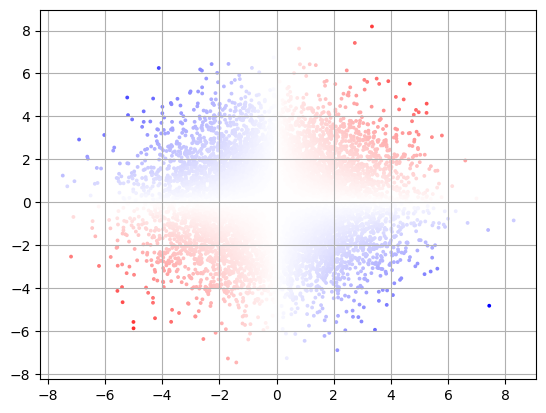

In [8]:
fig, ax = plt.subplots()
kwargs = dict(s=3, cmap='bwr', vmin=-cmax, vmax=cmax)
ax.scatter(X[:,0], X[:,1], c=y, **kwargs)
_ = ax.grid()

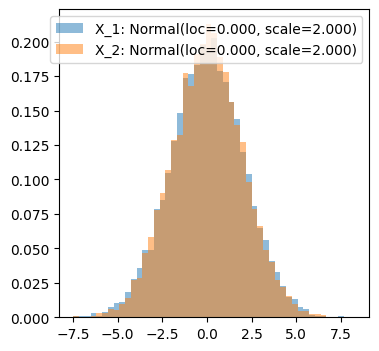

In [9]:
compare_histograms(X_1, X_2, c1_generator.distributions, c2_generator.distributions)

In [10]:
X = th.tensor(X).float()
y = th.tensor(y)

In [11]:
N_train = int(X.shape[0]*0.7)
N_val = int(X.shape[0]*0.15)
X_train = X[:N_train,:]
y_train = y[:N_train].float()
X_val = X[N_train:N_train+N_val,:]
y_val = y[N_train:N_train+N_val].float()
X_test = X[N_train+N_val:,:]
y_test = y[N_train+N_val:].float()

## RF

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
clf_rf = RandomForestRegressor(n_estimators=300, max_depth=12)

In [14]:
clf_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, n_estimators=300)

In [15]:
y_hat_rf = clf_rf.predict(X_test)

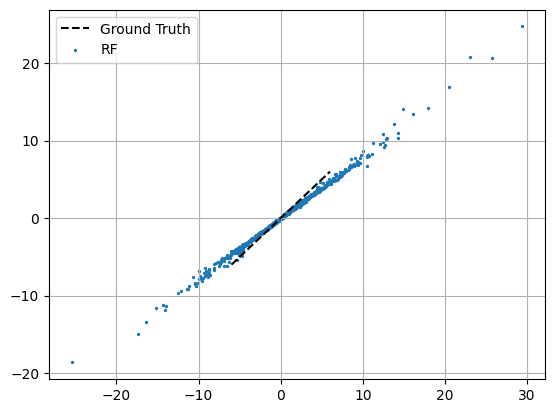

In [16]:
fig, ax = plt.subplots()
ax.plot([-6, 6], [-6, 6], label='Ground Truth', color='black', linestyle='--')
ax.scatter(y_test, y_hat_rf, s=2, label='RF')
ax.legend()
_ = ax.grid()

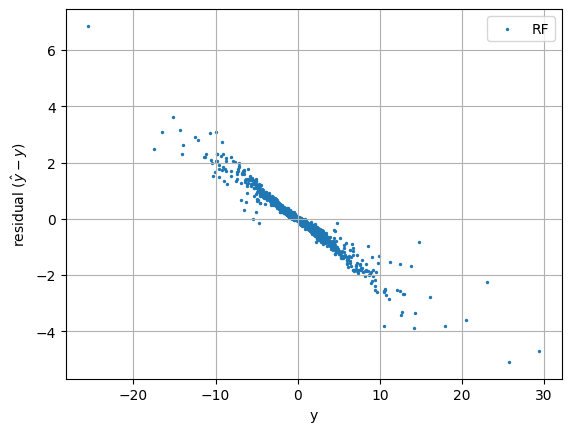

In [17]:
fig, ax = plt.subplots()
ax.scatter(y_test, (y_hat_rf-y_test.numpy()), s=2, label='RF')
ax.set(xlabel='y', ylabel='residual ($\hat{y}-y$)')
ax.legend()
_ = ax.grid()

## NNs

In [18]:
import torch as th
from torch import nn
from torch import optim
from torch.nn import functional as F

In [19]:
def train_regression(
        model, X_train, y_train, X_valid, y_valid, X_test, 
        epochs=200, lr=0.01, stop_criteria=5, l1_lambda=0.0, embed_smooth_lambda=0.0,
    ):
    opt = optim.Adam(model.parameters(), lr=lr)
    train_losses = list()
    valid_losses = list()
    min_test_ = 1e8
    es_counter = 0
    for e in range(epochs):
        model.train()
        opt.zero_grad()
        logits = model(X_train)
        loss = F.mse_loss(logits.flatten(), y_train.float())
        loss_l1 = 0
        embed_smooth = 0
        if hasattr(model, "__getitem__") and isinstance(model[0], NumericEmbedding):
            for name, parm in model[0].named_parameters():
                if 'embed' in name:
                    loss_l1 += th.sum(th.abs(parm))
                    embed_smooth += th.sum((parm[1:,:]-parm[:-1,:])**2)
            loss += l1_lambda*loss_l1+embed_smooth_lambda*embed_smooth
        loss.backward()
        opt.step()
        
        train_losses.append(loss.item())
        model.eval()
        with th.no_grad():
            y_hat_valid = model(X_valid).flatten()
            valid_loss = F.mse_loss(y_hat_valid, y_valid.float())
            valid_loss += l1_lambda*loss_l1 + embed_smooth_lambda*embed_smooth
            valid_losses.append(
                valid_loss.item()
            )
            if valid_losses[-1]<min_test_:
                min_test_ = valid_losses[-1]
                es_counter = 0
            else:
                es_counter += 1
                
        if es_counter > stop_criteria:
            print(f"Early stopping at epoch {e}")
            break
    model.eval()
    return train_losses, valid_losses, model(X_test).flatten().detach().numpy()

In [20]:
N_epochs = 5000
es_criteria = 10

In [21]:
# model_raw = nn.Linear(X.shape[1], 1)
# hidden_dim = 16
results = dict()
for hidden_dim in [1, 2, 4, 8, 16, 32, 64]:
    model_raw = nn.Sequential(
        nn.Linear(X.shape[1], hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1),
    )

    train_losses, test_losses, y_hat_raw = train_regression(
        model_raw, X_train, y_train, X_val, y_val, X_test, N_epochs, stop_criteria=es_criteria
    )
    results[hidden_dim] = y_hat_raw

Early stopping at epoch 983
Early stopping at epoch 460
Early stopping at epoch 618
Early stopping at epoch 970
Early stopping at epoch 1061
Early stopping at epoch 51
Early stopping at epoch 37


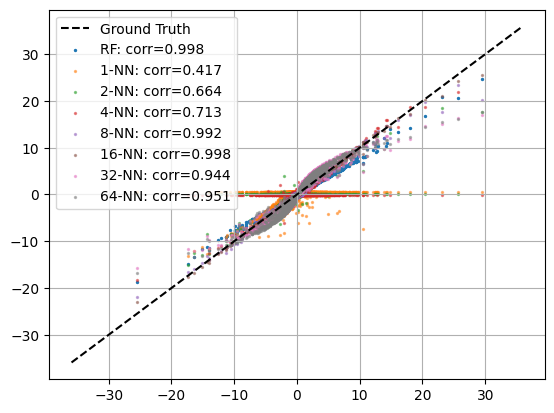

In [22]:
fig, ax = plt.subplots()
ax.plot([-cmax, cmax], [-cmax, cmax], label='Ground Truth', color='black', linestyle='--')
ax.scatter(y_test, y_hat_rf, s=2, label=f'RF: corr={pearsonr(y_test, y_hat_rf)[0]:.3f}')
for hidden_dim, y_hat in results.items():
    ax.scatter(y_test, y_hat, s=2, label=f'{hidden_dim}-NN: corr={pearsonr(y_test, y_hat)[0]:.3f}', alpha=0.5)
ax.legend()
_ = ax.grid()

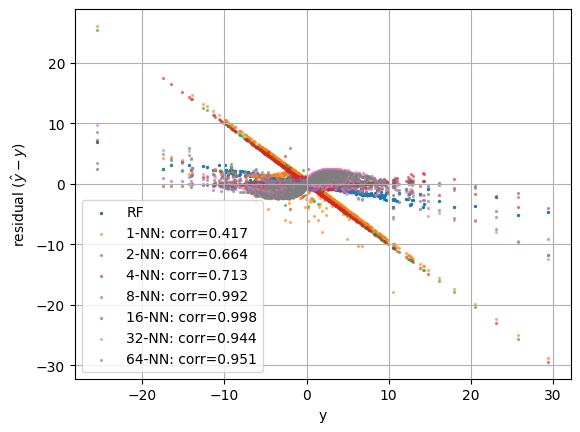

In [23]:
fig, ax = plt.subplots()
ax.scatter(y_test, (y_hat_rf-y_test.numpy()), s=2, label='RF')

for hidden_dim, y_hat in results.items():
    ax.scatter(y_test, (y_hat-y_test.numpy()), s=2, label=f'{hidden_dim}-NN: corr={pearsonr(y_test, y_hat)[0]:.3f}', alpha=0.5)

ax.set(xlabel='y', ylabel='residual ($\hat{y}-y$)')
ax.legend()
_ = ax.grid()

## Deep-dive w=2

In [24]:
hidden_dim = 2
model_raw = nn.Sequential(
    nn.Linear(X.shape[1], hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 1),
)

train_losses, test_losses, y_hat_raw = train_regression(
    model_raw, X_train, y_train, X_val, y_val, X_test, N_epochs, stop_criteria=es_criteria
)

Early stopping at epoch 510


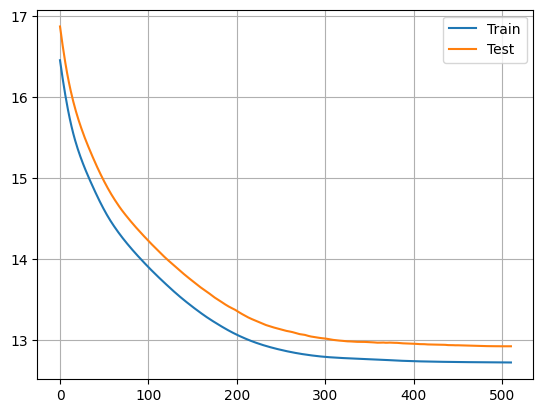

In [25]:
plot_losses(train_losses, test_losses)

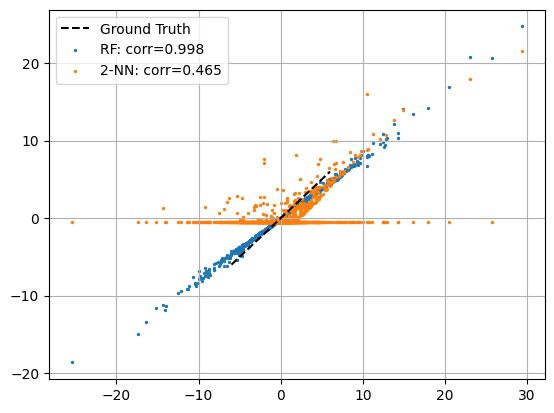

In [26]:
fig, ax = plt.subplots()
ax.plot([-6, 6], [-6, 6], label='Ground Truth', color='black', linestyle='--')
ax.scatter(y_test, y_hat_rf, s=2, label=f'RF: corr={pearsonr(y_test, y_hat_rf)[0]:.3f}')
ax.scatter(y_test, y_hat_raw, s=2, label=f'2-NN: corr={pearsonr(y_test, y_hat_raw)[0]:.3f}')
ax.legend()
_ = ax.grid()

In [27]:
# {n: p for n, p in model_raw[0].named_parameters()}

In [28]:
# X_test[:10,:]

In [29]:
# (X_test[:10,:] @ model_raw[0].weight.data.T).relu()

In [30]:
# model_raw[0].weight.data.T

In [31]:
with th.no_grad():
    h1 = model_raw[0](X_test).numpy()

In [32]:
# h1

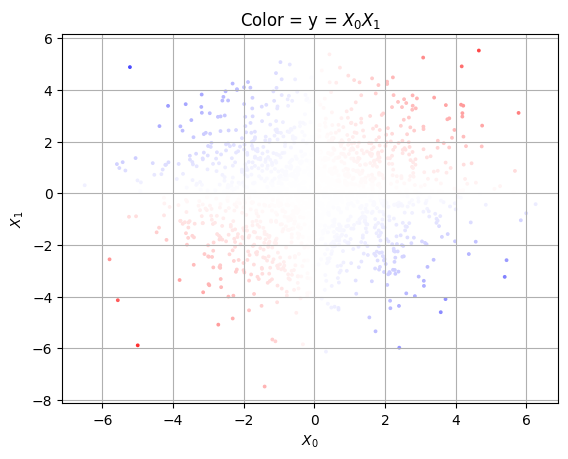

In [33]:
fig, ax = plt.subplots()
kwargs = dict(s=3, cmap='bwr', vmin=-cmax, vmax=cmax)
ax.scatter(X_test[:,0], X_test[:,1], c=y_test, **kwargs)
ax.set(xlabel='$X_0$', ylabel='$X_1$', title='Color = y = $X_0 X_1$')
_ = ax.grid()

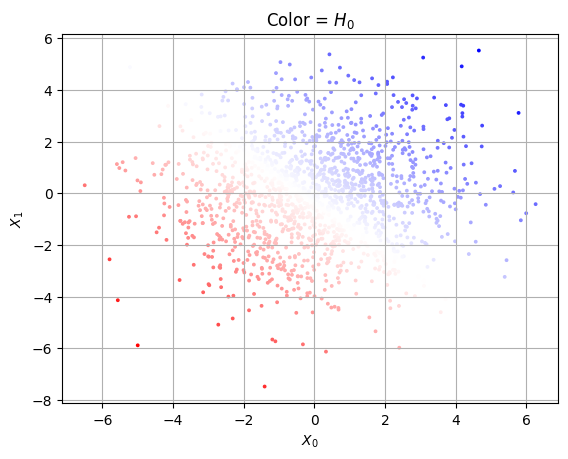

In [34]:
fig, ax = plt.subplots()
ax.scatter(X_test[:,0], X_test[:,1], c=h1[:,0], s=3, cmap='bwr')
ax.set(xlabel='$X_0$', ylabel='$X_1$', title='Color = $H_0$')
_ = ax.grid()

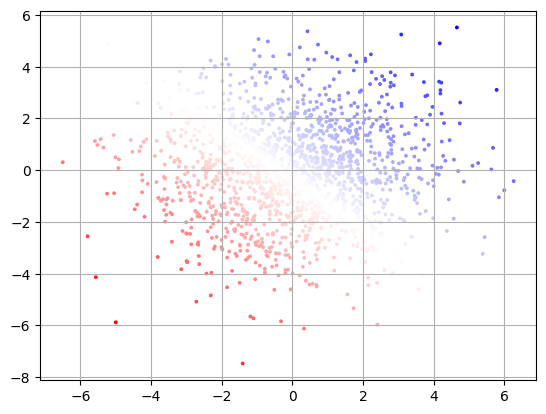

In [35]:
if h1.shape[1]>1:
    fig, ax = plt.subplots()
    ax.scatter(X_test[:,0], X_test[:,1], c=h1[:,1], s=3, cmap='bwr')
    _ = ax.grid()

In [36]:
if h1.shape[1]>2:
    fig, ax = plt.subplots()
    ax.scatter(X_test[:,0], X_test[:,1], c=h1[:,2], s=3, cmap='bwr')
    _ = ax.grid()

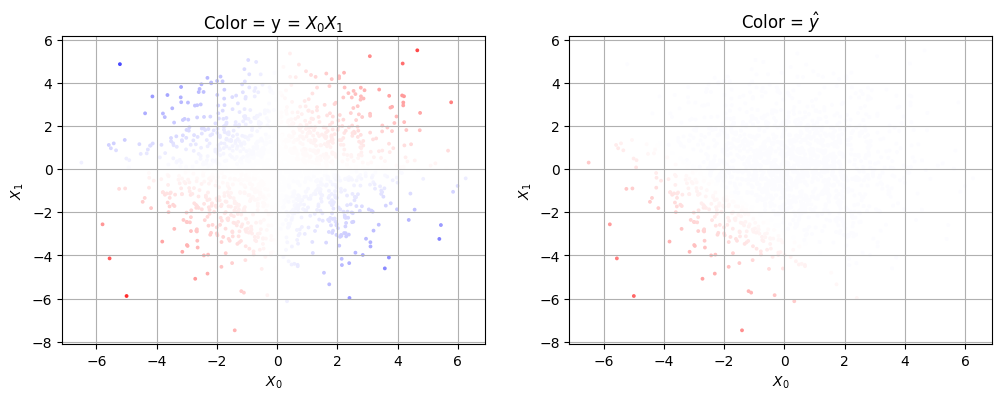

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
kwargs = dict(s=3, cmap='bwr', vmin=-cmax, vmax=cmax)
axs[0].scatter(X_test[:,0], X_test[:,1], c=y_test, **kwargs)
axs[0].set(xlabel='$X_0$', ylabel='$X_1$', title='Color = y = $X_0 X_1$')
_ = axs[0].grid()

axs[1].scatter(X_test[:,0], X_test[:,1], c=y_hat_raw, **kwargs)
axs[1].set(xlabel='$X_0$', ylabel='$X_1$', title='Color = $\hat y$')
_ = axs[1].grid()

## Use DTEs

In [131]:
Xs_dt, decision_trees, leaf_encoders = decision_tree_encoding(
    {'train': X_train, 'valid': X_val, 'test': X_test}, 
    {'train': y_train, 'valid': y_val, 'test': y_test}, 
#     min_impurity_decrease=1e-2, 
    max_splits=100,
    mode='random',
#     mode='regression',
)

In [132]:
n_uniques = (Xs_dt['train'].max(dim=0)[0]+1).numpy()
n_uniques

array([100, 100])

In [133]:
embed_dim = 1
hidden_dim = 256#2

model_dt = nn.Sequential(
    NumericEmbedding(n_uniques, embed_dim, 'concat'),
    nn.Linear(n_uniques.shape[0]*embed_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 1),
)

In [134]:
model_dt

Sequential(
  (0): NumericEmbedding(
    (embeds): ModuleList(
      (0): Embedding(100, 1)
      (1): Embedding(100, 1)
    )
  )
  (1): Linear(in_features=2, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=1, bias=True)
)

In [135]:
train_losses_dt, test_losses_dt, y_hat_dt = train_regression(
    model_dt, Xs_dt['train'], y_train, Xs_dt['valid'], y_val, Xs_dt['test'], 
    N_epochs, stop_criteria=200, #es_criteria, 
    embed_smooth_lambda=1e-2,
)

Early stopping at epoch 1395


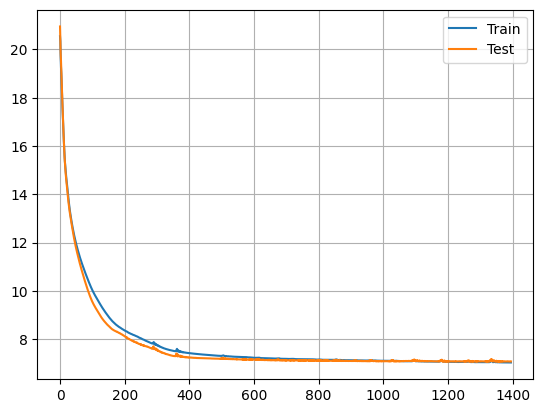

In [136]:
plot_losses(train_losses_dt, test_losses_dt)

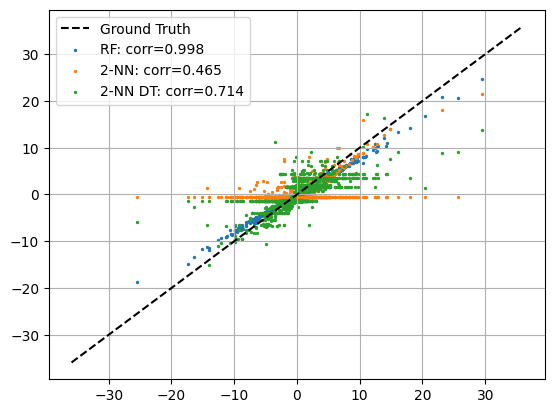

In [137]:
fig, ax = plt.subplots()
ax.plot([-cmax, cmax], [-cmax, cmax], label='Ground Truth', color='black', linestyle='--')
ax.scatter(y_test, y_hat_rf, s=2, label=f'RF: corr={pearsonr(y_test, y_hat_rf)[0]:.3f}')
ax.scatter(y_test, y_hat_raw, s=2, label=f'2-NN: corr={pearsonr(y_test, y_hat_raw)[0]:.3f}')
ax.scatter(y_test, y_hat_dt, s=2, label=f'2-NN DT: corr={pearsonr(y_test, y_hat_dt)[0]:.3f}')
ax.legend()
_ = ax.grid()

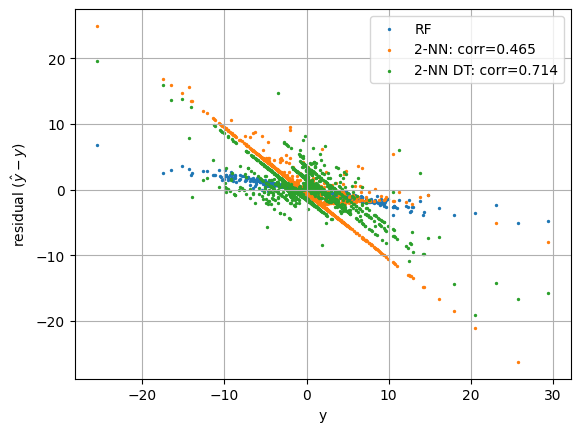

In [138]:
fig, ax = plt.subplots()
ax.scatter(y_test, (y_hat_rf-y_test.numpy()), s=2, label='RF')
ax.scatter(y_test, (y_hat_raw-y_test.numpy()), s=2, label=f'2-NN: corr={pearsonr(y_test, y_hat_raw)[0]:.3f}')
ax.scatter(y_test, (y_hat_dt-y_test.numpy()), s=2, label=f'2-NN DT: corr={pearsonr(y_test, y_hat_dt)[0]:.3f}')

ax.set(xlabel='y', ylabel='residual ($\hat{y}-y$)')
ax.legend()
_ = ax.grid()

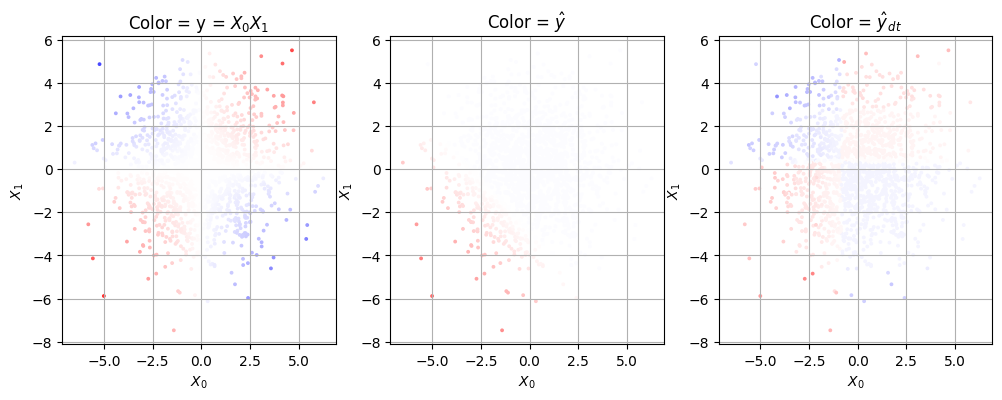

In [139]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
kwargs = dict(s=3, cmap='bwr', vmin=-cmax, vmax=cmax)
axs[0].scatter(X_test[:,0], X_test[:,1], c=y_test, **kwargs)
axs[0].set(xlabel='$X_0$', ylabel='$X_1$', title='Color = y = $X_0 X_1$')
_ = axs[0].grid()

axs[1].scatter(X_test[:,0], X_test[:,1], c=y_hat_raw, **kwargs)
axs[1].set(xlabel='$X_0$', ylabel='$X_1$', title='Color = $\hat y$')
_ = axs[1].grid()

axs[2].scatter(X_test[:,0], X_test[:,1], c=y_hat_dt, **kwargs)
axs[2].set(xlabel='$X_0$', ylabel='$X_1$', title='Color = $\hat y_{dt}$')
_ = axs[2].grid()

In [140]:
with th.no_grad():
    X_embed_train = model_dt[0](Xs_dt['train']).numpy()
    X_embed_val = model_dt[0](Xs_dt['valid']).numpy()
    X_embed_test = model_dt[0](Xs_dt['test']).numpy()

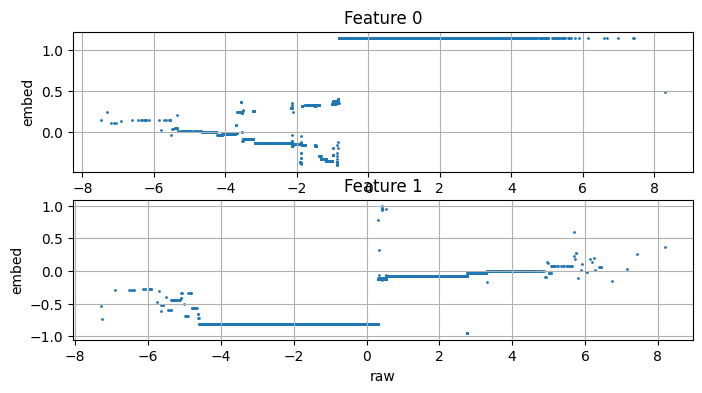

In [141]:
#Raw vs learned
fig, axs = plt.subplots(X_embed_train.shape[1], 1, figsize=(4*X_embed_train.shape[1], 4))
if not hasattr(axs, '__iter__'):
    axs = [axs]

for idx, ax in enumerate(axs):
    _ = ax.scatter(X_train[:, idx], X_embed_train[:, idx], s=1)
    ax.set(xlabel='raw', ylabel='embed', title=f'Feature {idx}')
    _ = ax.grid()

The decision trees can learn nothing about the output with a single feature, and therefore the space segmentation is not useful.  

To see this more clearly, consider the XOR problem.  Each feature can have 0/1, which will map to some embedding.  But given the value of one of the embeddings, there are equal number of data-points with `y==0` as `y==1`, corresponding to the values of the other feature.  Considering each feature independently, there's simply no way to remap it to get information about the other feature.

Question:  what if both features can be present when growing the trees?

In [49]:
from sklearn.ensemble import RandomForestRegressor, RandomTreesEmbedding, GradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

In [50]:
def decision_tree_encoding_multi(
        Xs, ys, tree_kwargs, mode='classification',
    ):
    
    dts = list()
    les = list()
    X_train_dt = th.zeros_like(Xs['train']).long()
    X_valid_dt = th.zeros_like(Xs['valid']).long()
    X_test_dt = th.zeros_like(Xs['test']).long()
    if mode=='classification':
        # todo
        pass
    elif mode=='regression':
#         dtc = RandomForestRegressor(**tree_kwargs)
        dtc = GradientBoostingRegressor(**tree_kwargs)
    elif mode=='random':
        dtc = RandomTreesEmbedding(**tree_kwargs)
    dtc.fit(Xs['train'], ys['train'])
    dts.append(dtc)
    le = OrdinalEncoder()
    X_train_dt = th.tensor(
        le.fit_transform(
            dtc.apply(Xs['train'])
        )
    ).long()
    X_valid_dt = th.tensor(
        le.transform(
            dtc.apply(Xs['valid'])
        )
    ).long()
    X_test_dt = th.tensor(
        le.transform(
            dtc.apply(Xs['test'])
        )
    ).long()
    les.append(le)
    
    Xs_dt = dict(
        train=X_train_dt,
        valid=X_valid_dt,
        test=X_test_dt,
    )
    return Xs_dt, dts, les

In [51]:
tree_kwargs = dict(
    n_estimators=300,
    learning_rate=0.1,
    subsample=0.25,
    max_depth=12,
    max_leaf_nodes=100,
    loss='lad', # least_absolute_error
#     max_leaf_nodes=10,
#     min_impurity_decrease=1e-3,
#     max_samples=0.25,
#     max_depth=12,
)
Xs_dt_multi, decision_trees_multi, leaf_encoders_multi = decision_tree_encoding_multi(
    {'train': X_train, 'valid': X_val, 'test': X_test}, 
    {'train': y_train, 'valid': y_val, 'test': y_test}, 
#     mode='random',
    mode='regression',
    tree_kwargs=tree_kwargs,
)

In [52]:
n_uniques_multi = (Xs_dt_multi['train'].max(dim=0)[0]+1).numpy()
n_uniques_multi

array([ 15,  63,  75, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100,  94, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100,  81, 100, 100,  78,  68, 100, 100, 100,
       100,  39, 100, 100,  90, 100, 100, 100, 100,  36, 100,  98, 100,
       100, 100, 100, 100, 100,  93, 100,  82, 100, 100, 100, 100, 100,
       100,  88, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,  48,
       100, 100, 100, 100, 100,  67, 100,  87, 100, 100, 100, 100, 100,
       100, 100, 100,  91, 100, 100, 100,  95, 100, 100, 100, 100, 100,
       100, 100,  87, 100, 100, 100, 100,  44, 100, 100, 100, 100,  98,
       100,  66,  88,  98, 100, 100, 100,  44, 100, 100, 100, 100,  73,
       100,  98,  29, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100,  98,  68,  71,  96,  46, 100, 100, 100, 100,  63, 100, 100,
       100, 100, 100, 100,  96, 100, 100, 100, 100, 100, 100, 10

In [53]:
embed_dim = 1
hidden_dim = 1

model_dt_multi = nn.Sequential(
    NumericEmbedding(n_uniques_multi, embed_dim, 'concat'),
    nn.Linear(n_uniques_multi.shape[0]*embed_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 1),
)

In [54]:
model_dt_multi

Sequential(
  (0): NumericEmbedding(
    (embeds): ModuleList(
      (0): Embedding(15, 1)
      (1): Embedding(63, 1)
      (2): Embedding(75, 1)
      (3): Embedding(100, 1)
      (4): Embedding(100, 1)
      (5): Embedding(100, 1)
      (6): Embedding(100, 1)
      (7): Embedding(100, 1)
      (8): Embedding(100, 1)
      (9): Embedding(100, 1)
      (10): Embedding(100, 1)
      (11): Embedding(100, 1)
      (12): Embedding(100, 1)
      (13): Embedding(100, 1)
      (14): Embedding(100, 1)
      (15): Embedding(100, 1)
      (16): Embedding(100, 1)
      (17): Embedding(100, 1)
      (18): Embedding(100, 1)
      (19): Embedding(100, 1)
      (20): Embedding(100, 1)
      (21): Embedding(100, 1)
      (22): Embedding(100, 1)
      (23): Embedding(100, 1)
      (24): Embedding(100, 1)
      (25): Embedding(100, 1)
      (26): Embedding(100, 1)
      (27): Embedding(100, 1)
      (28): Embedding(100, 1)
      (29): Embedding(94, 1)
      (30): Embedding(100, 1)
      (31): Embedding

In [55]:
train_losses_dt_multi, test_losses_dt_multi, y_hat_dt_multi = train_regression(
    model_dt_multi, Xs_dt_multi['train'], y_train, Xs_dt_multi['valid'], y_val, Xs_dt_multi['test'], 
    N_epochs, stop_criteria=es_criteria, 
#     embed_smooth_lambda=1e-2,
)

Early stopping at epoch 2477


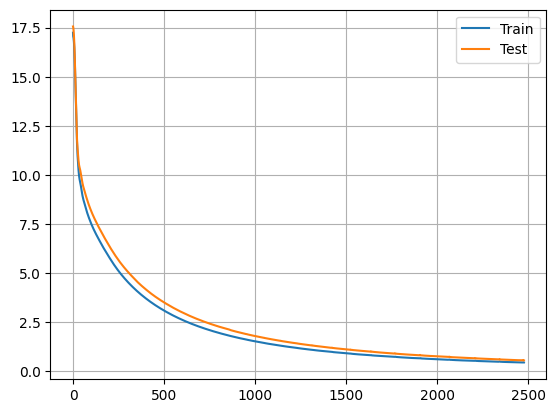

In [56]:
plot_losses(train_losses_dt_multi, test_losses_dt_multi)

/Users/jostza/venvs/graphlytics/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


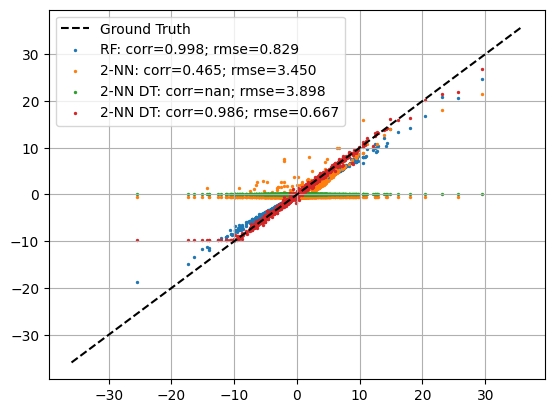

In [57]:
fig, ax = plt.subplots()
ax.plot([-cmax, cmax], [-cmax, cmax], label='Ground Truth', color='black', linestyle='--')
ax.scatter(
    y_test, y_hat_rf, s=2, 
    label=f'RF: corr={pearsonr(y_test, y_hat_rf)[0]:.3f}; rmse={np.sqrt(mse(y_test, y_hat_rf)):.3f}')
ax.scatter(
    y_test, y_hat_raw, s=2, 
    label=f'2-NN: corr={pearsonr(y_test, y_hat_raw)[0]:.3f}; rmse={np.sqrt(mse(y_test, y_hat_raw)):.3f}')
ax.scatter(
    y_test, y_hat_dt, s=2, 
    label=f'2-NN DT: corr={pearsonr(y_test, y_hat_dt)[0]:.3f}; rmse={np.sqrt(mse(y_test, y_hat_dt)):.3f}')
ax.scatter(
    y_test, y_hat_dt_multi, s=2, 
    label=f'2-NN DT: corr={pearsonr(y_test, y_hat_dt_multi)[0]:.3f}; rmse={np.sqrt(mse(y_test, y_hat_dt_multi)):.3f}')

ax.legend()
_ = ax.grid()

/Users/jostza/venvs/graphlytics/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


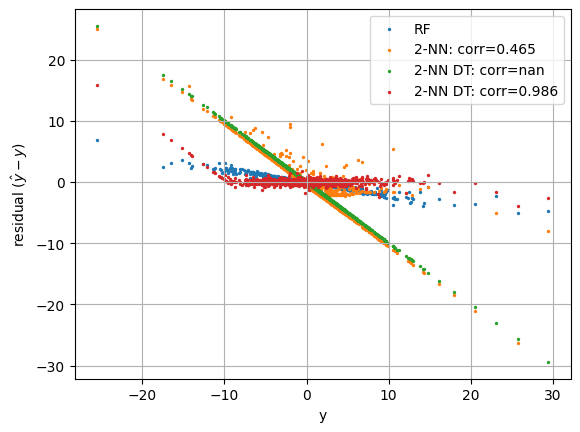

In [58]:
fig, ax = plt.subplots()
ax.scatter(y_test, (y_hat_rf-y_test.numpy()), s=2, label='RF')
ax.scatter(y_test, (y_hat_raw-y_test.numpy()), s=2, label=f'2-NN: corr={pearsonr(y_test, y_hat_raw)[0]:.3f}')
ax.scatter(y_test, (y_hat_dt-y_test.numpy()), s=2, label=f'2-NN DT: corr={pearsonr(y_test, y_hat_dt)[0]:.3f}')
ax.scatter(y_test, (y_hat_dt_multi-y_test.numpy()), s=2, 
    label=f'2-NN DT: corr={pearsonr(y_test, y_hat_dt_multi)[0]:.3f}')


ax.set(xlabel='y', ylabel='residual ($\hat{y}-y$)')
ax.legend()
_ = ax.grid()

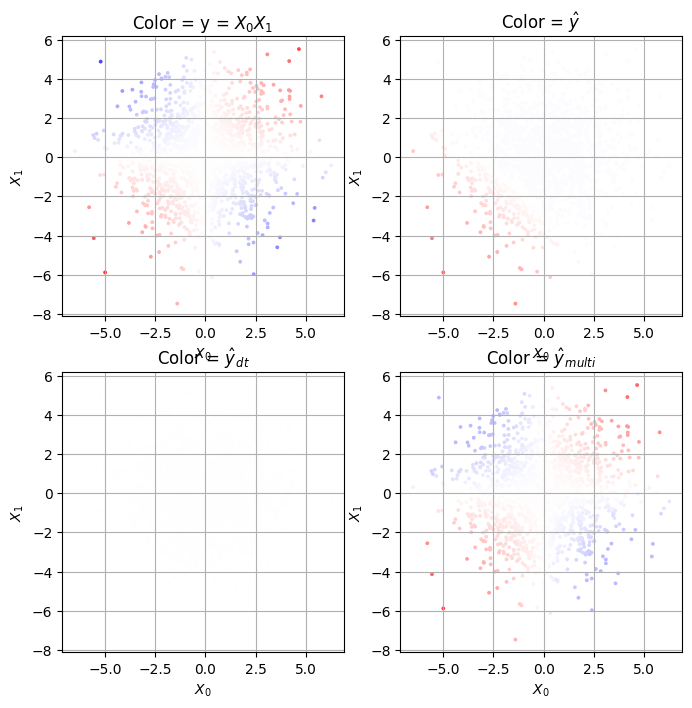

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
kwargs = dict(s=3, cmap='bwr', vmin=-cmax, vmax=cmax)
axs[0][0].scatter(X_test[:,0], X_test[:,1], c=y_test, **kwargs)
axs[0][0].set(xlabel='$X_0$', ylabel='$X_1$', title='Color = y = $X_0 X_1$')
_ = axs[0][0].grid()

axs[0][1].scatter(X_test[:,0], X_test[:,1], c=y_hat_raw, **kwargs)
axs[0][1].set(xlabel='$X_0$', ylabel='$X_1$', title='Color = $\hat y$')
_ = axs[0][1].grid()

axs[1][0].scatter(X_test[:,0], X_test[:,1], c=y_hat_dt, **kwargs)
axs[1][0].set(xlabel='$X_0$', ylabel='$X_1$', title='Color = $\hat y_{dt}$')
_ = axs[1][0].grid()

axs[1][1].scatter(X_test[:,0], X_test[:,1], c=y_hat_dt_multi, **kwargs)
axs[1][1].set(xlabel='$X_0$', ylabel='$X_1$', title='Color = $\hat y_{multi}$')
_ = axs[1][1].grid()

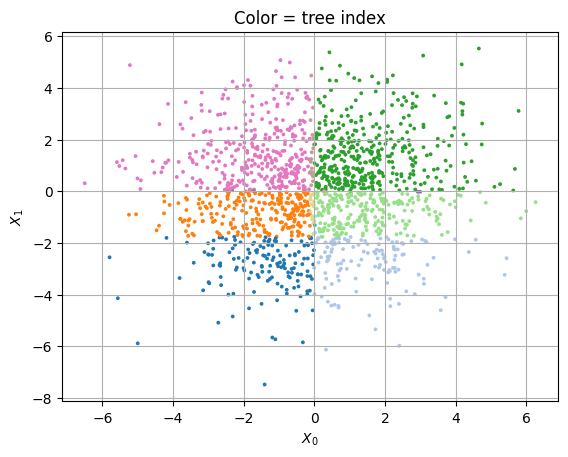

In [60]:
fig, ax = plt.subplots()
ax.scatter(X_test[:,0], X_test[:,1], s=3, c=Xs_dt_multi['test'][:,0], cmap='tab20')
ax.set(xlabel='$X_0$', ylabel='$X_1$', title='Color = tree index')
_ = ax.grid()

In [61]:
with th.no_grad():
    X_embed_train_multi = model_dt_multi[0](Xs_dt_multi['train']).numpy()
    X_embed_val_multi = model_dt_multi[0](Xs_dt_multi['valid']).numpy()
    X_embed_test_multi = model_dt_multi[0](Xs_dt_multi['test']).numpy()

In [62]:
#Raw vs learned
# fig, axs = plt.subplots(X_embed_train_multi.shape[1], 1, figsize=(4*X_embed_train_multi.shape[1], 4))
# if not hasattr(axs, '__iter__'):
#     axs = [axs]

# for idx, ax in enumerate(axs):
#     _ = ax.scatter(X_train[:, idx], X_embed_train_multi[:, idx], s=1)
#     ax.set(xlabel='raw', ylabel='embed', title=f'Feature {idx}')
#     _ = ax.grid()

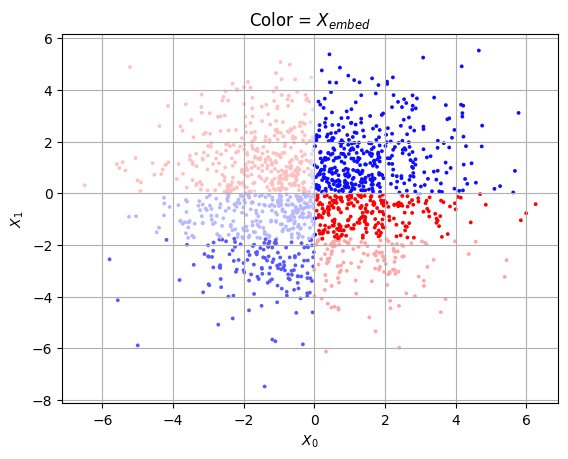

In [63]:
fig, ax = plt.subplots()
ax.scatter(X_test[:,0], X_test[:,1], s=3, c=X_embed_test_multi[:,0], cmap='bwr')
ax.set(xlabel='$X_0$', ylabel='$X_1$', title='Color = $X_{embed}$')
_ = ax.grid()

# Just add an embedding + linear to RF leaf index

In [64]:
le = OrdinalEncoder()
X_rf_train = th.tensor(le.fit_transform(clf_rf.apply(X_train))).long()
X_rf_val = th.tensor(le.transform(clf_rf.apply(X_val))).long()
X_rf_test = th.tensor(le.transform(clf_rf.apply(X_test))).long()

In [65]:
n_uniques_rf = (X_rf_train.max(dim=0)[0]+1).numpy()
n_uniques_rf

array([ 737,  592,  264,  183, 1178,  207,  242,  251,  385,  336,  483,
        232,  336,  102,  300,  675,  474,  119,  180,  303,  162,  467,
         93,  236,  630,  300,  281,  161, 1147,  510, 1206, 1795,  815,
        104, 1115,  169, 1753,  318,  270,  798,  769,  146,  915, 1479,
        117, 1030,  592,  106,  370,  308,  303,  227,  122,  264,  327,
        289,  475, 1787,  229,  665,  771,  342,  135,  299,  226,  984,
        481,  106,  116,  236,  207,  419, 1159,  219,  462,  460,  469,
        114,  426,  477,  427,  126,  699,  389,  279,  508,  316, 1843,
        477,  234, 1077,  275,  145,  143,  759, 1046, 1206,  290,  395,
        217,  897, 1091, 1036,  324,  272,   90,  534,  314,  380,  161,
        441,  411,  688,  148,  158, 1515,  141,  747,  498,   64,   81,
        452,  103, 1109,  186,  287,  615,  357,  455,  525,  484, 1738,
         84, 1092,  226, 1128,  201,  117,  251,   64, 1792,  224,  154,
        602,  123,  683,  104,  299,  442,  519,  8

In [66]:
embed_dim = 1
hidden_dim = 1

model_dt_rf = nn.Sequential(
    NumericEmbedding(n_uniques_rf, embed_dim, 'concat'),
    nn.Linear(n_uniques_rf.shape[0]*embed_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 1),
)

In [67]:
sum([p.numel() for p in model_dt_rf.parameters()])

142278

In [68]:
train_losses_dt_rf, test_losses_dt_rf, y_hat_dt_rf = train_regression(
    model_dt_rf, X_rf_train, y_train, X_rf_val, y_val, X_rf_test, 
    N_epochs, stop_criteria=es_criteria, 
#     embed_smooth_lambda=1e-2,
)

Early stopping at epoch 2110


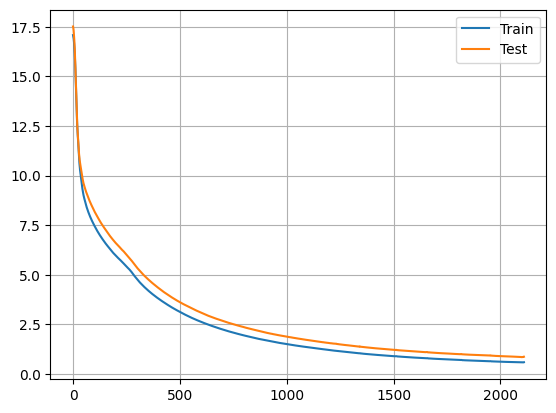

In [69]:
plot_losses(train_losses_dt_rf, test_losses_dt_rf)

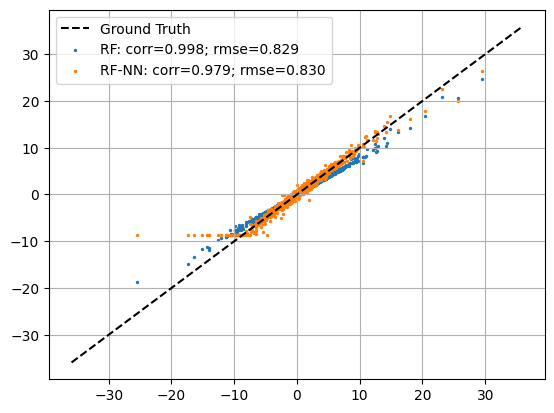

In [70]:
fig, ax = plt.subplots()
ax.plot([-cmax, cmax], [-cmax, cmax], label='Ground Truth', color='black', linestyle='--')
ax.scatter(
    y_test, y_hat_rf, s=2, 
    label=f'RF: corr={pearsonr(y_test, y_hat_rf)[0]:.3f}; rmse={np.sqrt(mse(y_test, y_hat_rf)):.3f}')

ax.scatter(
    y_test, y_hat_dt_rf, s=2, 
    label=f'RF-NN: corr={pearsonr(y_test, y_hat_dt_rf)[0]:.3f}; rmse={np.sqrt(mse(y_test, y_hat_dt_rf)):.3f}')
# ax.scatter(
#     y_test, y_hat_raw, s=2, 
#     label=f'2-NN: corr={pearsonr(y_test, y_hat_raw)[0]:.3f}; rmse={np.sqrt(mse(y_test, y_hat_raw)):.3f}')
# ax.scatter(
#     y_test, y_hat_dt, s=2, 
#     label=f'2-NN DT: corr={pearsonr(y_test, y_hat_dt)[0]:.3f}; rmse={np.sqrt(mse(y_test, y_hat_dt)):.3f}')
# ax.scatter(
#     y_test, y_hat_dt_multi, s=2, 
#     label=f'2-NN DT: corr={pearsonr(y_test, y_hat_dt_multi)[0]:.3f}; rmse={np.sqrt(mse(y_test, y_hat_dt_multi)):.3f}')

ax.legend()
_ = ax.grid()

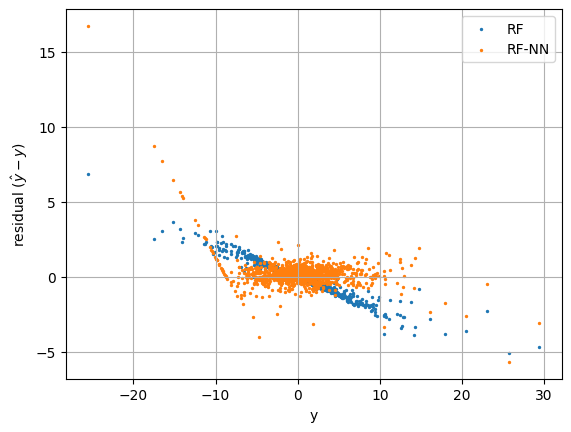

In [71]:
fig, ax = plt.subplots()
ax.scatter(y_test, (y_hat_rf-y_test.numpy()), s=2, label='RF')
ax.scatter(y_test, (y_hat_dt_rf-y_test.numpy()), s=2, label='RF-NN')
# ax.scatter(y_test, (y_hat_raw-y_test.numpy()), s=2, label=f'2-NN: corr={pearsonr(y_test, y_hat_raw)[0]:.3f}')
# ax.scatter(y_test, (y_hat_dt-y_test.numpy()), s=2, label=f'2-NN DT: corr={pearsonr(y_test, y_hat_dt)[0]:.3f}')
# ax.scatter(y_test, (y_hat_dt_multi-y_test.numpy()), s=2, 
#     label=f'2-NN DT: corr={pearsonr(y_test, y_hat_dt_multi)[0]:.3f}')


ax.set(xlabel='y', ylabel='residual ($\hat{y}-y$)')
ax.legend()
_ = ax.grid()